In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import scipy
import tensorflow_io as tfio


2024-08-19 13:02:47.278170: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 13:02:47.284023: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 13:02:47.299009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 13:02:47.326788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 13:02:47.335013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 13:02:47.358544: I tensorflow/core/platform/cpu_feature_gu

In [10]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [1]:
import os
import scipy.io.wavfile as wavfile
import scipy.signal

def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=16000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

def resample_audio_files(dataset_path, desired_sample_rate=16000):
    # Iterate through train and test folders
    for split in ['train', 'test']:
        split_folder = os.path.join(dataset_path, split)
        for class_folder in os.listdir(split_folder):
            class_folder_path = os.path.join(split_folder, class_folder)
            for audio_file in os.listdir(class_folder_path):
                if audio_file.endswith('.wav'):  # Process only .wav files
                    audio_path = os.path.join(class_folder_path, audio_file)
                    
                    # Read the audio file
                    original_sample_rate, waveform = wavfile.read(audio_path)
                    
                    # Resample the audio if needed
                    new_sample_rate, new_waveform = ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate)
                    
                    # Save the resampled audio
                    wavfile.write(audio_path, new_sample_rate, new_waveform.astype('int16'))  # Ensure correct data type

if __name__ == "__main__":
    dataset_path = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/audioset-download/audioset'  # Replace with your dataset path
    resample_audio_files(dataset_path, desired_sample_rate=16000)
    print('done')


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


FileNotFoundError: [Errno 2] No such file or directory: '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/audioset-download/audioset/train'

In [64]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav


In [65]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')


Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


## Create a DataFrame

In [66]:
import os
import pandas as pd

def create_dataframe_from_directories(base_path, class_folders):
    # List to hold information about each file
    data = []
    
    # Loop through each class folder
    for class_name in class_folders:
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            # List all .wav files in the class folder
            for filename in os.listdir(class_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(class_path, filename)
                    data.append({'filename': file_path, 'category': class_name})
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage
base_data_path = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/'
class_folders = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']
df = create_dataframe_from_directories(base_data_path, class_folders)


In [67]:
# Define your classes and map them to IDs
my_classes = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']
map_class_to_id = {cls: idx for idx, cls in enumerate(my_classes)}

# Filter DataFrame for specified classes (if needed)
filtered_df = df[df['category'].isin(my_classes)]

# Map class names to IDs
filtered_df['class_id'] = filtered_df['category'].apply(lambda name: map_class_to_id[name])

# Optionally, add a full path column if needed
#filtered_df['full_path'] = filtered_df['filename'].apply(lambda row: os.path.abspath(row))

# Display the DataFrame
print(filtered_df.head(550))


                                              filename      category  class_id
0    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
1    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
2    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
3    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
4    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
..                                                 ...           ...       ...
479  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
480  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
481  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
482  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
483  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4

[484 rows x 3 columns]


In [68]:
for i in enumerate(my_classes):

    print(i)

(0, 'Speech')
(1, 'Silence')
(2, 'Music')
(3, 'Beep')
(4, 'Robot_moving')


In [69]:

filenames = filtered_df['filename'].tolist()
targets = filtered_df['class_id'].tolist()

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds=main_ds.shuffle(buffer_size=1000)

# Function to print dataset labels
def print_dataset_labels(dataset, num_samples=500):
    for i, (filename, target) in enumerate(dataset.take(num_samples)):

            print(f"Sample {i+1}: Filename = {filename.numpy()}, Class ID = {target.numpy()}")
        
print_dataset_labels(main_ds)

Sample 1: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Music/1K1rV9kFs6I_30.0-40.0.wav', Class ID = 2
Sample 2: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Music/1NEybsmFECg_30.0-40.0.wav', Class ID = 2
Sample 3: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Silence/-V4WO7a8Lbk_70.0-80.0.wav', Class ID = 1
Sample 4: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Beep/74kJeRfUN0c_30.0-40.0.wav', Class ID = 3
Sample 5: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Silence/-1hvn3ZCTAU_0.0-10.0.wav', Class ID = 1
Sample 6: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Speech/N5NGtmtnz_c_0.0-10.0.wav', Class ID = 0
Sample 7: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/train/Speech/2ZfwEg4JaiU_0.0-10.0.wav', Class ID = 0
Sample 8: Filename = b'/home/focus/Bureau/Audi

In [70]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [71]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))
            

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [72]:


# Shuffle the dataset
shuffled_ds = main_ds.shuffle(buffer_size=len(filenames), reshuffle_each_iteration=False)

# Define the split proportions
train_size = int(0.8 * len(filenames))
val_size = int(0.1 * len(filenames))
test_size = int(0.1 * len(filenames))

# Split the dataset
train_ds = shuffled_ds.take(train_size)
remaining_ds = shuffled_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
remaining_ds = shuffled_ds.skip(val_size)
test_ds=val_ds = remaining_ds.take(val_size)

# Print dataset specs for verification
print("Train dataset:", train_ds.element_spec)
print("Validation dataset:", val_ds.element_spec)



Train dataset: (TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
Validation dataset: (TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [73]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE).repeat()
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)



tf.io.read_file

<function tensorflow.python.ops.io_ops.read_file(filename, name=None)>

In [74]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()


Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,365 (2.01 MB)

 Trainable params: 527,365 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)


In [76]:
history = my_model.fit(train_ds,
                       epochs=20,
                       steps_per_epoch=400,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8313 - loss: 0.7021 - val_accuracy: 0.4167 - val_loss: 2.4309
Epoch 2/20
  8/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9557 - loss: 0.1753

2024-08-19 13:27:54.548146: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9384 - loss: 0.2381 - val_accuracy: 0.4792 - val_loss: 2.1200
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9442 - loss: 0.1205 - val_accuracy: 0.4167 - val_loss: 2.4566
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9419 - loss: 0.1097 - val_accuracy: 0.4167 - val_loss: 2.5826
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9431 - loss: 0.1164 - val_accuracy: 0.4167 - val_loss: 2.6718
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9430 - loss: 0.1042 - val_accuracy: 0.4375 - val_loss: 2.7754
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9446 - loss: 0.1041 - val_accuracy: 0.4167 - val_loss: 2.9992
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9435 - loss: 0.1043 - val_accuracy: 0.4167 - val_loss: 3.1628
Epoch 9/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9455 - loss: 0.1015 - val_accuracy: 0.416

2024-08-19 13:28:36.281645: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9462 - loss: 0.0984 - val_accuracy: 0.4167 - val_loss: 3.2361
Epoch 11/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9459 - loss: 0.1001 - val_accuracy: 0.4375 - val_loss: 3.2910
Epoch 12/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9498 - loss: 0.0954 - val_accuracy: 0.4375 - val_loss: 3.3417
Epoch 13/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9487 - loss: 0.0983 - val_accuracy: 0.4375 - val_loss: 3.4060
Epoch 14/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9452 - loss: 0.1001 - val_accuracy: 0.5000 - val_loss: 3.3973
Epoch 15/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9471 - loss: 0.0983 - val_accuracy: 0.4375 - val_loss: 3.4991


In [119]:
wav=load_wav_16k_mono('/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Silence/-v5tNN6YADM_0.0-10.0.wav')

In [120]:
scores, embeddings, spectrogram = yamnet_model(wav)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'My model :The main sound is: {inferred_class}')


My model :The main sound is: Speech


In [115]:
result.mean(axis=0)

array([-6.5671134,  3.3958538, -3.763562 , -6.002507 ,  4.0054936],
      dtype=float32)

In [121]:

scores, embeddings, spectrogram = yamnet_model(wav)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'Yamnet : The main sound is: {inferred_class}')

Yamnet : The main sound is: Silence


Enregistrer un modèle qui peut directement prendre un fichier WAV en entrée

In [122]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [123]:
saved_model_path = './pleasesave'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


TypeError: Exception encountered when calling layer 'yamnet' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=float32, sparse=None, name=audio>,) and kwargs: {} for signature: (waveform: TensorSpec(shape=(None,), dtype=tf.float32, name=None)).

Call arguments received by layer 'yamnet' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=float32, sparse=None, name=audio>
  • training=None

In [131]:
import tensorflow as tf

# Define the path where the final model will be saved
saved_model_path = './pleasesave/hahaha123.keras'

# Load the YAMNet model


# Define the input tensor spec (audio waveform)
inpu_segment = tf.keras.Input(shape=(), dtype=tf.float32, name='audio_input')

# Wrap the YAMNet model call in a Lambda layer
embeddings_output = tf.keras.layers.Lambda(lambda x: yamnet_model(x)[1,name='extraction'])(inpu_segment)

# Pass the embeddings to your custom classification model
serving_outputs = my_model(embeddings_output)

# Apply a ReduceMean layer to aggregate the outputs (if needed)
serving_outputs = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='5_class_classifier')(serving_outputs)

# Create the final model
serving_model = tf.keras.Model(inputs=inpu_segment, outputs=serving_outputs)

# Save the model as a SavedModel
serving_model.save(saved_model_path)


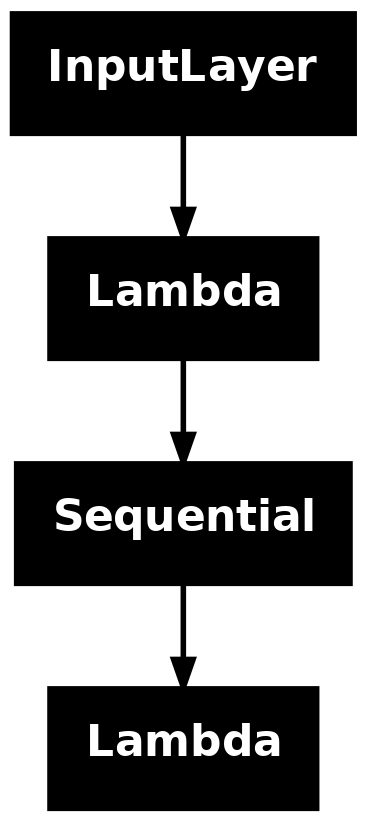

In [142]:
tf.keras.utils.plot_model(serving_model)



### load model

In [140]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model from TensorFlow Hub or your saved model path
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'  # or use your saved model path
yamnet_model = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')

# Define the input tensor spec (audio waveform)
input_segment = tf.keras.Input(shape=(None,), dtype=tf.float32, name='audio_input')

# Wrap the YAMNet model call in a Lambda layer with explicit output shape
def extract_embeddings(x):
    _, embeddings, _ = yamnet_model(x)
    return embeddings

embeddings_output = tf.keras.layers.Lambda(
    lambda x: extract_embeddings(x),
    output_shape=(1024,),  # Specify the output shape of the embeddings
    name='embeddings_output'
)(input_segment)

# Load or define your custom classification model
# For this example, I'll assume `my_model` is a simple dense network


# Pass the embeddings to your custom classification model
serving_outputs = my_model(embeddings_output)

# Apply a ReduceMean layer to aggregate the outputs (if needed)
serving_outputs = tf.keras.layers.Lambda(
    lambda x: tf.reduce_mean(x, axis=0),
    name='5_class_classifier'
)(serving_outputs)

# Create the final model
serving_model = tf.keras.Model(inputs=input_segment, outputs=serving_outputs)

# Define the path where the final model will be saved
saved_model_path = './pleasesave/hahaha123.keras'

# Save the model as a SavedModel
serving_model.save(saved_model_path)


In [165]:
import tensorflow as tf

# Define the path where the model will be saved as a folder
saved_model_folder_path = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/saving_costum_yamnet'

# Adjust input shape according to the model's expected input
input_segment = tf.keras.Input(shape=(), dtype=tf.float32, name='audio_input')

# Define the YAMNet model's embedding extraction layer (Ensure correct shape and layer configurations)
def extract_embeddings(x):
    return yamnet_model(x)[1]  # Assuming this extracts the embedding

embeddings_output = tf.keras.layers.Lambda(
    extract_embeddings, 
    output_shape=(1024,),  # Adjust this according to actual embeddings output
    name='embeddings_output'
)(input_segment)

# Pass the embeddings to your custom classification model
serving_outputs = my_model(embeddings_output)

# Apply a ReduceMean layer to aggregate the outputs (if needed)
serving_outputs = tf.keras.layers.Lambda(
    lambda x: tf.reduce_mean(x, axis=0),
    name='5_class_classifier'
)(serving_outputs)

# Create the final model
serving_model = tf.keras.Model(inputs=input_segment, outputs=serving_outputs)

# Save the model as a TensorFlow SavedModel folder
tf.saved_model.save(serving_model, saved_model_folder_path)


AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_serving_default_334025'
	Captured Tensor = <ResourceHandle(name="layer1/conv/kernel/730", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="tensorflow::Var", dtype and shapes : "[ DType enum: 1, Shape: [3,3,1,32] ]")>
	Trackable referencing this tensor = <tf.Variable 'layer1/conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
	Internal Tensor = Tensor("333741:0", shape=(), dtype=resource)

In [159]:
saved_model_path = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/saving_costum_yamnet/'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
#embedding_extraction_layer = hub.KerasLayer(yamnet_model,
                                            #trainable=False, name='yamnet')
#embeddings_output = embedding_extraction_layer(input_segment)[1]
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
#serving_model.save(saved_model_path, include_optimizer=False)
tf.saved_model.save(serving_model, saved_model_path)


KeyError: in user code:

    File "/home/focus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/layer.py", line 120, in serving_default  *
        return self(inputs)
    File "/home/focus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/focus/.local/lib/python3.10/site-packages/keras/src/ops/function.py", line 179, in _run_through_graph
        output_tensors.append(tensor_dict[id(x)])

    KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m131117707213168\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None,), dtype=float32)\n  • training=None\n  • mask=None'


In [14]:
from tensorflow import keras

In [15]:
reloaded_model=keras.layers.TFSMLayer('/home/focus/Bureau/Audio_Node/src/resources/ray_audio/trained_custom_5classes', call_endpoint='serving_default')

In [56]:
type(reloaded_model)

keras.src.export.export_lib.TFSMLayer

In [16]:
wav=load_wav_16k_mono('/home/focus/Bureau/Audio_Node/src/resources/ray_audio/test_wav/music.wav')

In [17]:
my_classes = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']

In [18]:
result=reloaded_model(wav)
prediction=my_classes[tf.argmax(result['output_0'])]
print(f'the predicted class is {prediction}')

the predicted class is Speech


In [105]:
print((tf.argmin(wav)))

tf.Tensor(137435, shape=(), dtype=int64)


### Real time prediction

In [62]:
import pyaudio

In [127]:
# Audio stream parameters
import collections
my_classes = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000  # YAMNet expects 16kHz audio
CHUNK = 8000  # Number of audio samples per frame
#model = hub.load('https://tfhub.dev/google/yamnet/1')
audio_buffer = collections.deque(maxlen=RATE)

def process_audio(audio_data):
    # Convert audio data to float32
    audio_data = audio_data.astype(np.float32)

    # audio_data /= np.max(np.abs(audio_data))  # Now audio_data is in the range [0, 1]

    # # Scale and shift to [-0.6, 0.7]
    # min_val = -0.6
    # max_val = 0.7
    # audio_data = audio_data * (max_val - min_val) + min_val

    # Normalize the audio data to the range [-1, 1]
    audio_data =audio_data/ 32767
    # audio_data = audio_data * (max_val - min_val) + min_val
    print(audio_data)

    # You might also consider standardizing the data (optional):
    # audio_data = (audio_data - np.mean(audio_data)) / np.std(audio_data)
    # print(audio_data)
    # Make predictions
    result = reloaded_model(audio_data)
    prediction=my_classes[tf.argmax(result['output_0'])]

    # Post-process the scores
    # predictions = np.mean(scores, axis=0)
    # top_class = np.argmax(predictions)
    # top_score = predictions[top_class]
    
    print(f'The main sound is: {prediction}')

    #print(f"Predicted class: {top_class}, Score: {top_score}")

def audio_callback(in_data, frame_count, time_info, status):
    # Process the audio data here
    audio_data = np.frombuffer(in_data, dtype=np.int16)
    # You can pass this data to your model for prediction
    process_audio(audio_data)
    return (in_data, pyaudio.paContinue)

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                stream_callback=audio_callback)

stream.start_stream()

try:
    while stream.is_active():
        pass  # Keep the stream active
except KeyboardInterrupt:
    pass

stream.stop_stream()
stream.close()
p.terminate()

# Load the YAMNet model



ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'


[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  3.051851e-05 -3.051851e-05
 -9.155553e-05]
The main sound is: Robot_moving
[-1.8311106e-04 -2.1362957e-04 -1.8311106e-04 ... -9.1555528e-05
 -3.0518509e-05 -3.0518509e-05]
The main sound is: Speech
[3.0518509e-05 1.2207404e-04 1.5259255e-04 ... 0.0000000e+00 9.1555528e-05
 9.1555528e-05]
The main sound is: Speech
[ 0.0000000e+00 -9.1555528e-05 -1.5259255e-04 ... -1.5259255e-04
 -2.4414808e-04 -3.3570360e-04]
The main sound is: Speech
[-0.00018311 -0.00021363 -0.0003357  ... -0.00015259 -0.00042726
 -0.00042726]
The main sound is: Speech
[-3.3570360e-04 -3.9674062e-04 -3.3570360e-04 ...  1.8311106e-04
  6.1037019e-05 -1.8311106e-04]
The main sound is: Speech
[-3.9674062e-04 -3.6622211e-04 -2.7466659e-04 ... -2.4414808e-04
 -1.8311106e-04  3.0518509e-05]
The main sound is: Speech
[-6.1037019e-05 -2.4414808e-04 -4.2725913e-04 ... -1.2207404e-04
 -1.5259255e-04 -9.1555528e-05]
The main sound is: Speech
[-3.0518509e-05  3.0518509e-05  1.831110

In [95]:
import tensorflow as tf
import numpy as np
import os
import glob

def process_wav_file(wav_file):
    # Load the WAV file
    audio = load_wav_16k_mono(wav_file)
    #audio, _ = tf.audio.decode_wav(audio_binary)

    # Flatten the audio tensor
    # audio_flat = tf.reshape(audio, [-1])

    # Calculate argmax and argmin
    max_index = tf.argmax(audio)
    min_index = tf.argmin(audio)

    return max_index, min_index

def compute_average_argmax_argmin(wav_files):
    max_indices = []
    min_indices = []

    for wav_file in wav_files:
        max_index, min_index = process_wav_file(wav_file)
        max_indices.append(max_index.numpy())
        min_indices.append(min_index.numpy())

    # Compute average of max and min indices
    avg_max_index = np.mean(max_indices)
    avg_min_index = np.mean(min_indices)

    return avg_max_index, avg_min_index

# Replace this with the path to your folder containing WAV files
wav_folder = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Silence'
wav_files = glob.glob(os.path.join(wav_folder, '*.wav'))

avg_max_index, avg_min_index = compute_average_argmax_argmin(wav_files)

print(f"Average argmax: {avg_max_index}")
print(f"Average argmin: {avg_min_index}")


Average argmax: 57864.22727272727
Average argmin: 60761.545454545456


### audio prediction

In [128]:
def normalize_audio_data(audio_data):
    # Convert audio data to float32
    audio_data = audio_data.astype(np.float32)
    
    # Normalize to the range [-1, 1]
    audio_data /= np.max(np.abs(audio_data))
    
    return audio_data


In [132]:
import pyaudio
import numpy as np
import tensorflow as tf

# Define constants
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
my_classes = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']

# Load the trained model


def process_audio(audio_data):
    # Convert audio data to float32
    audio_data = audio_data.astype(np.float32)
    
    # Normalize to the range [-1, 1]
    audio_data /= np.max(np.abs(audio_data))
    
    # Ensure audio data is in the expected shape
    audio_data = np.expand_dims(audio_data, axis=0)
    
    # Make predictions
    result = reloaded_model(audio_data)
    prediction_index = tf.argmax(result['output_0'], axis=-1).numpy()
    prediction = my_classes[prediction_index[0]]
    
    return prediction

def callback(in_data, frame_count, time_info, status):
    # Convert in_data to numpy array
    audio_data = np.frombuffer(in_data, dtype=np.int16)
    
    # Process the audio data
    prediction = process_audio(audio_data)
    print("Prediction:", prediction)
    
    return (in_data, pyaudio.paContinue)

# Initialize PyAudio
p = pyaudio.PyAudio()

try:
    # Open the stream
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK,
                    stream_callback=callback)
    
    # Start the stream
    stream.start_stream()
    
    # Keep the stream open
    while stream.is_active():
        try:
            pass
        except KeyboardInterrupt:
            break
finally:
    # Stop and close the stream
    if stream.is_active():
        stream.stop_stream()
    stream.close()
    
    # Terminate PyAudio
    p.terminate()


ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'


InvalidArgumentError: Exception encountered when calling TFSMLayer.call().

[1mGraph execution error:

Detected at node yamnet_frames/tf_op_layer_Pad/Pad defined at (most recent call last):
<stack traces unavailable>
The first dimension of paddings must be the rank of inputs[1,2] [1,1024]
	 [[{{node yamnet_frames/tf_op_layer_Pad/Pad}}]] [Op:__inference_signature_wrapper___call___70676][0m

Arguments received by TFSMLayer.call():
  • inputs=tf.Tensor(shape=(1, 1024), dtype=float32)
  • training=False
  • kwargs=<class 'inspect._empty'>

TypeError: InvalidArgumentError.__init__() missing 3 required positional arguments: 'node_def', 'op', and 'message'

In [90]:
import os
import pandas as pd

def create_dataframe_from_directories(base_path, class_folders):
    # List to hold information about each file
    data = []
    
    # Loop through each class folder
    for class_name in class_folders:
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            # List all .wav files in the class folder
            for filename in os.listdir(class_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(class_path, filename)
                    data.append({'filename': file_path, 'category': class_name})
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage
base_data_path = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test'
class_folders = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']
t_df = create_dataframe_from_directories(base_data_path, class_folders)


In [95]:
# Define your classes and map them to IDs
my_classes = ['Speech', 'Silence', 'Music', 'Beep', 'Robot_moving']
map_class_to_id = {cls: idx for idx, cls in enumerate(my_classes)}

# Filter DataFrame for specified classes (if needed)
filtered_df = t_df[t_df['category'].isin(my_classes)]

# Map class names to IDs
filtered_df['class_id'] = filtered_df['category'].apply(lambda name: map_class_to_id[name])

# Optionally, add a full path column if needed
#filtered_df['full_path'] = filtered_df['filename'].apply(lambda row: os.path.abspath(row))

# Display the DataFrame
print(filtered_df.head(550))


                                              filename      category  class_id
0    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
1    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
2    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
3    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
4    /home/focus/Bureau/Audio_Node/src/resources/ra...        Speech         0
..                                                 ...           ...       ...
118  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
119  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
120  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
121  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4
122  /home/focus/Bureau/Audio_Node/src/resources/ra...  Robot_moving         4

[123 rows x 3 columns]


In [97]:

filenames = filtered_df['filename'].tolist()
targets = filtered_df['class_id'].tolist()

test_main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
test_main_ds=test_main_ds.shuffle(buffer_size=1000)

# Function to print dataset labels
def print_dataset_labels(dataset, num_samples=500):
    for i, (filename, target) in enumerate(dataset.take(num_samples)):

            print(f"Sample {i+1}: Filename = {filename.numpy()}, Class ID = {target.numpy()}")
        
print_dataset_labels(test_main_ds)

Sample 1: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Speech/-pjK2u3Qtxc_230.0-240.0.wav', Class ID = 0
Sample 2: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Silence/-twSsq6Rj_I_140.0-150.0.wav', Class ID = 1
Sample 3: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Silence/0VRt6ENphpA_80.0-90.0.wav', Class ID = 1
Sample 4: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Silence/-iGr_xpHqCk_360.0-370.0.wav', Class ID = 1
Sample 5: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Beep/MOotHT2iJzI_30.0-40.0.wav', Class ID = 3
Sample 6: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Beep/EotkYg493i0_7.0-17.0.wav', Class ID = 3
Sample 7: Filename = b'/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata/test/Beep/iD7p9-Ds3Dw_3.0-13.0.wav', Class ID = 3
Sample 8: Filename = b'/home/focus/Bureau/Audio

In [100]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

test_main_ds = test_main_ds.map(load_wav_for_map)
test_main_ds.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [102]:
test_dss = main_ds.take(123)
test_dss = test_dss.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
loss, accuracy = my_model.evaluate(test_dss)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [43]:
predictions = tf.argmax(result['output_0'])

In [58]:
predictions

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [89]:
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()  # Use SparseCategoricalAccuracy for integer labels
loss_metric = tf.keras.metrics.Mean()

# Iterate through the test dataset
for inputs, labels in test_ds:
    # Make predictions
    predictions = my_model(inputs)
    
    # If predictions are in a dictionary, extract the relevant tensor
    if isinstance(predictions, dict):
        predictions = predictions['output_0']  # Adjust key based on your model's output

    # Ensure predictions have the correct shape
    if len(predictions.shape) == 1:
        predictions = tf.expand_dims(predictions, axis=-1)
    
    # Check predictions shape
    print("Predictions shape:", predictions.shape)

    # Compute loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)
    loss_metric.update_state(tf.reduce_mean(loss))
    
    # Update accuracy
    accuracy_metric.update_state(labels, tf.argmax(predictions, axis=-1))

# Print results
print("Test Loss:", loss_metric.result().numpy())
print("Test Accuracy:", accuracy_metric.result().numpy())

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [159619] and element 16 had shape [54465]. [Op:IteratorGetNext] name: 

In [62]:
import tensorflow as tf

# Load the model


# Inspect available signatures
print("Available Signatures:")
for signature_key in reloaded_model.signatures:
    print(signature_key)
    signature = reloaded_model.signatures[signature_key]
    print("Input Signature:", signature.inputs)
    print("Output Signature:", signature.outputs)


Available Signatures:


AttributeError: 'TFSMLayer' object has no attribute 'signatures'

In [155]:
dog = tf.saved_model.load('/home/focus/Bureau/Audio_Node/src/resources/ray_audio/')


OSError: SavedModel file does not exist at: /home/focus/Bureau/Audio_Node/src/resources/ray_audio//{saved_model.pbtxt|saved_model.pb}